# Catalog testing

**Author:** Xavier R Nogueira

**Overview:** The intake catalog will be the core of our first server implementation. Reading data descriptions, drivers, and locations from the catalog will allow xpublish to meet the expected OPeNDAP endpoint functionality. Later on we will also (potentially) implement read-in from a STAC catalog.

In [76]:
import intake
import intake_xarray
import panel
import xarray as xr
import fsspec
import zarr
from pathlib import Path

In [3]:
INTAKE_CATALOG_DIR = Path.cwd().parent / 'intake_catalogs'

# find a YAML intake catalogs
intake_yamls = []
for cat in INTAKE_CATALOG_DIR.iterdir():
    if cat.suffix == '.yml':
        intake_yamls.append(cat)
print(intake_yamls)

[WindowsPath('C:/Users/xrnogueira/Documents/Xpublish-OPeNDAP-Server/intake_catalogs/sample_zarr_catalog.yml')]


In [4]:
catalog = intake.open_catalog(intake_yamls[0])
catalog

sample_zarr_catalog:
  args:
    path: C:\Users\xrnogueira\Documents\Xpublish-OPeNDAP-Server\intake_catalogs\sample_zarr_catalog.yml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


Column(width_policy='max')
    [0] Row(width_policy='max')
        [0] PNG(str)
        [1] Column(width_policy='max')
            [0] Column(name='Select Catalog')
                [0] Markdown(str, max_height=40)
                [1] MultiSelect(min_width=200, options={'sample_zarr_catalog': <...}, size=9, value=[<Intake catalog: s...], width_policy='min')
            [1] Row(name='Controls')
                [0] Toggle(name='＋', width=50)
                [1] Button(name='―', width=50)
                [2] Toggle(name='🔍', width=50)
        [2] Column(width_policy='max')
            [0] Column(name='Select Data Source')
                [0] Markdown(str, max_height=40)
                [1] MultiSelect(min_width=200, options=OrderedDict([('conus404-ho...]), size=9, value=[name: conus404-hourly-s3
...], width_policy='min')
            [1] Row(name='Controls')
                [0] Toggle(name='📊', width=50)
                [1] Toggle(disabled=True, name='⚙', width=50)
        [3] Column(height=240, name='Description', scroll=True, sizing_mode='stretch_width', width_policy='max')
            [0] Markdown(str)
    [1] Row(width_policy='max')
        [0] Row(height_policy='min', max_width=5000, name='Search', width_policy='max')
        [1] Column(max_width=5000, name='Add Catalog', width_policy='max')
        [2] Column(name='Plot', width_policy='max')
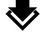

In [7]:
# check if the catalog was loaded correct
intake.interface.gui.GUI([catalog])

In [47]:
type(catalog['prism-v2-osn'])

intake_xarray.xzarr.ZarrSource

In [90]:
cat_info = catalog['prism-v2-osn'].describe()
cat_info

{'name': 'prism-v2-osn',
 'container': 'xarray',
 'plugin': ['zarr'],
 'driver': ['zarr'],
 'description': 'USGS THREDDS Holdings/Parameter-elevation Regressions on Independent Slopes Model Monthly Climate Data for the Continental United States',
 'direct_access': 'forbid',
 'user_parameters': [],
 'metadata': {},
 'args': {'urlpath': 's3://rsignellbucket2/nhgf/sample_data/prism_v2.zarr',
  'consolidated': True,
  'storage_options': {'anon': True,
   'requester_pays': False,
   'client_kwargs': {'endpoint_url': 'https://renc.osn.xsede.org'}}}}

In [105]:
xr.engines

AttributeError: module 'xarray' has no attribute 'engines'

In [99]:
intake.registry.keys()

['alias',
 'catalog',
 'csv',
 'intake_remote',
 'json',
 'jsonl',
 'ndzarr',
 'numpy',
 'textfiles',
 'tiled',
 'tiled_cat',
 'yaml_file_cat',
 'yaml_files_cat',
 'zarr_cat',
 'netcdf',
 'opendap',
 'rasterio',
 'remote-xarray',
 'xarray_image',
 'zarr',
 'remote_xarray']

In [84]:
type(catalog)

intake.catalog.local.YAMLFileCatalog

In [ ]:
catalog['prism-v2-osn'].discover()

In [101]:
catalog['prism-v2-osn'].urlpath

's3://rsignellbucket2/nhgf/sample_data/prism_v2.zarr'

In [67]:
k = catalog['prism-v2-osn'].describe()['args']['storage_options']#['client_kwargs']
k

{'anon': True,
 'requester_pays': False,
 'client_kwargs': {'endpoint_url': 'https://renc.osn.xsede.org'}}

In [79]:
from fsspec.mapping import FSMap

In [127]:
%%time
fs = fsspec.filesystem(
    's3',
    **k,
)
open_s3 = fs.open(
    catalog['prism-v2-osn'].urlpath,
)

s3_map = FSMap(catalog['prism-v2-osn'].urlpath, fs)

ds = xr.open_dataset(
    s3_map,
    engine='zarr'#cat_info['driver'][0],
)
ds

CPU times: total: 46.9 ms
Wall time: 1.05 s


<xarray.Dataset>
Dimensions:    (lat: 621, lon: 1405, time: 1512, tbnd: 2)
Coordinates:
  * lat        (lat) float32 49.94 49.9 49.85 49.81 ... 24.23 24.19 24.15 24.1
  * lon        (lon) float32 -125.0 -125.0 -124.9 -124.9 ... -66.6 -66.56 -66.52
  * time       (time) datetime64[ns] 1895-01-01 1895-02-01 ... 2020-12-01
Dimensions without coordinates: tbnd
Data variables:
    ppt        (time, lat, lon) float64 ...
    time_bnds  (time, tbnd) datetime64[ns] ...
    tmn        (time, lat, lon) float32 ...
    tmx        (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.4

In [83]:
ds['ppt']

<xarray.DataArray 'ppt' (time: 1512, lat: 621, lon: 1405)>
[1319227560 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 49.94 49.9 49.85 49.81 ... 24.23 24.19 24.15 24.1
  * lon      (lon) float32 -125.0 -125.0 -124.9 -124.9 ... -66.6 -66.56 -66.52
  * time     (time) datetime64[ns] 1895-01-01 1895-02-01 ... 2020-12-01
Attributes:
    long_name:  Mean monthly precipitation
    units:      mm/month

In [133]:
%%time
# start a s3 filesystem
fs = fsspec.filesystem('s3', **{})

# open the file and return as a dataset
s3_map = fs.open(
    r's3://era5-pds/2008/01/data/air_temperature_at_2_metres.nc',
)
ds2 = xr.open_dataset(
    s3_map,
    engine='h5netcdf',
)


CPU times: total: 688 ms
Wall time: 27.6 s


**WOW, opening from zarr is 27x faster even with a bigger dataset due to chunking!** Pretty crazy

In [120]:
ds2

<xarray.Dataset>
Dimensions:                      (lon: 1440, lat: 721, time0: 744)
Coordinates:
  * lon                          (lon) float32 0.0 0.25 0.5 ... 359.5 359.8
  * lat                          (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * time0                        (time0) datetime64[ns] 2008-01-01 ... 2008-0...
Data variables:
    air_temperature_at_2_metres  (time0, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts